# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

# The setting given

$$ C = w_M * L_M + w_F * L_F $$

$$ Q = C^\omega * H^(1-\omega) $$

$$ T_M = L_M + H_M $$

$$ T_F = L_F + H_F $$

$$ L_M, H_M, L_F, H_F >= 0 $$

$$ T_M, T_F <= 24 $$

# Setting the basics

In [3]:
%load_ext autoreload
%autoreload 2

from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

import math as math

from scipy.optimize import minimize, minimize_scalar


ModuleNotFoundError: No module named 'numpy'

In [2]:
import household as model
hsm = model.HouseholdSpecializationModelClass()

model=hsm
par =model.par
sol =model.sol

alpha_vector = [0.25, 0.5, 0.75]
sigma_vector = [0.5, 1, 1.5]

df = pd.DataFrame(columns=alpha_vector, index=sigma_vector)

ModuleNotFoundError: No module named 'numpy'

# Question 1

**Explain how you solve the model**

In [6]:
#Minimum i household.py virker ikke pt, skal der kigges på 
#Det er løst for sigma=1 og alpha=0.5, der skal findes ud af hvordan man løse for alle de værdier opgivet i opgaven
dsol = hsm.solve_discrete()

print(f'HF: {dsol.HF} for alpha and sigma: {hsm.par.alpha, hsm.par.sigma}')
print(f'HM: {dsol.HM} for alpha and sigma: {hsm.par.alpha, hsm.par.sigma}')

print(dsol.HF/dsol.HM)

/Users/camillamansson/Dropbox/KU/2. semester/Introduction to Programming/projects-2023-jc/inauguralproject/household.py:68: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


HF: 4.5 for alpha and sigma: (0.5, 1.0)
HM: 4.5 for alpha and sigma: (0.5, 1.0)
1.0


In [8]:
for i in alpha_vector:
    for j in sigma_vector:
        hsm.par.alpha = i
        hsm.par.sigma = j
        results = hsm.solve_discrete()
        ratio = results.HF/results.HM
        df.loc[j,i] = ratio

#Printing the results for the ratio between H_F and H_M
print(df)

4.5


NameError: name 'HF' is not defined

# Question 2

Explain your code and procedure

In [4]:
#Test af log (skal ikke bruges)
logHM = math.log(dsol.HM)
logHF = math.log(dsol.HF)
logwF = math.log(par.wF)
logwM = math.log(par.wM)

# log til opgave 2 for H og w
logH = math.log(dsol.HF/dsol.HM)
logw = math.log(par.wM/par.wF)
print(logH)
print(logw)

0.0
0.0


Comments and conclusion:


# Question 3

Explain your code and procedure

Comments and conclusion

# Question 4

In [15]:
#a
# define the function to compute min_HF
def min_HF(a, sigma, W_M, W_F):     #We want to claculate the minimum value of homeproduction for men and women given certain parameter values
    if sigma == 0:
        return W_F / W_M
    else:
        H_M = 1     #For simplicity we assume that men and women are equally productive, therefore we set H_M=1
        H_F = ((W_M ** (1 - a) * W_F ** a) ** (sigma / (1 - a))) * H_M  # We assumed W_M = W_F = 1 and substituting the other values in H we simplify H_F
        return min(H_M, H_F)


# define the function to compute beta0_hat and beta1_hat for a given a, sigma, and range of W_M and W_F
def compute_betas(a, sigma, w_range): #w_range indicates the different values for W_M and W_F that will be used to calculate beta0_hat and beta1_hat
    beta0_hat = 0
    beta1_hat = 0
    n = 0
    for W_F in w_range:
        for W_M in w_range:
            if W_M != W_F:
                # compute log(H_F/H_M) and log(W_F/W_M)
                log_HF_HM = np.log(min_HF(a, sigma, W_M, W_F))
                log_WF_WM = np.log(W_F / W_M)
                
                # update the sum of log(W_F/W_M) and log(H_F/H_M)
                beta0_hat += log_HF_HM
                beta1_hat += log_WF_WM
                n += 1   #n is being incremented by 1 each time a valid observation is used in the calculation
                
    # divide by the number of observations to get the averages
    beta0_hat /= n
    beta1_hat /= n
    
    return beta0_hat, beta1_hat

# set the values of a and sigma to try
a_values = np.linspacea(0.2, 0.4, 0.6, 0.8)
sigma_values = [0, 0.5, 1, 1.5, 2]

# define the function to compute the minimum distance between the estimated and actual betas
def compute_distance(a, sigma):
    # compute beta0_hat and beta1_hat for the current a and sigma
    beta0_hat, beta1_hat = compute_betas(a, sigma, [0.8, 0.9, 1.0, 1.1, 1.2]) #The values are given in the task as the range for W_F and W_M
        
    # compute the distance between the estimated betas and the actual betas
    distance = (beta0 - beta0_hat)**2 + (beta1 - beta1_hat)**2   #The formula for Euclidean distance between two points also given in the text
        
    return distance   #The 'return' statement is used to send this distance value back to the caller of the function so that it can be used for further processing or analysis

# initialize the variables
best_a = None      #Set as none, could also have been set to 0. The same is valid for best_sigma
best_sigma = None
min_distance = float('inf')   #float('inf') is a special floating-point value that represents positive infinity. It is used here to initialize min_distance to a very large number so that any distance calculated in the loop will be smaller than min_distance at the beginning.

# loop over all combinations of a and sigma
#This code uses a nested loop to iterate over all combinations of a and sigma values provided in a_values and sigma_values
for a in a_values:
    for sigma in sigma_values:
        # compute the distance between the estimated and actual betas for the current a and sigma
        distance = compute_distance(a, sigma)
        
        # check if this is the best combination so far
        if distance < min_distance: # the function is comparing the current distance between the estimated and actual betas (computed using the current values of a and sigma) to the minimum distance found so fa
            best_a = a
            best_sigma = sigma
            min_distance = distance    

# print the best values of a and sigma
print(f"Best values: a={best_a}, sigma={best_sigma}")

#b

import numpy as np
import matplotlib.pyplot as plt

#In this part we will be plotting a model. We start by minimizing in an alternative way to the previous in part a
# define the function to compute log(H_F/H_M)
def log_HF_HM(a, sigma, W_M, W_F):
    if sigma == 0:
        H_F = W_F**a * W_M**(1-a)
        H_M = W_M
    else:
        H_F = (W_F**(a*(1-sigma)) * (W_M**(1-sigma))**((1-a)*sigma))**(1/(1-sigma))
        H_M = (W_M**(a*(1-sigma)) * (W_F**(1-sigma))**(a*sigma))**(1/(1-sigma))
    return np.log(H_F/H_M)

# set the values of W_M and W_F to plot
W_M_values = np.linspace(0.1, 2, 100)
W_F_values = np.linspace(0.1, 2, 100)

# create a meshgrid of W_M and W_F values
W_M_grid, W_F_grid = np.meshgrid(W_M_values, W_F_values)

# compute the log(H_F/H_M) values for each combination of W_M and W_F
log_HF_HM_grid = log_HF_HM(best_a, best_sigma, W_M_grid, W_F_grid)

# plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W_M_grid, W_F_grid, log_HF_HM_grid, cmap='coolwarm')
ax.set_xlabel('W_M')
ax.set_ylabel('W_F')
ax.set_zlabel('log(H_F/H_M)')
plt.show()


AttributeError: module 'numpy' has no attribute 'linspacea'

Comments and conclusion

4.a 

We estimated that the best value for alpha is 0.1 and for sigma it is 0. An interpretation of the result would be that home production is more productive for women than for men, with a ratio of aboit 1,1(1,1/1). This is due to alpha representing the weight of women's wages in the production function (H_F defined in the code) and the productivity of home production is the same for men and women since sigma is 0. This implies that the ratio of women's to men's home production is constant regardless to the level of wages. 

4.b
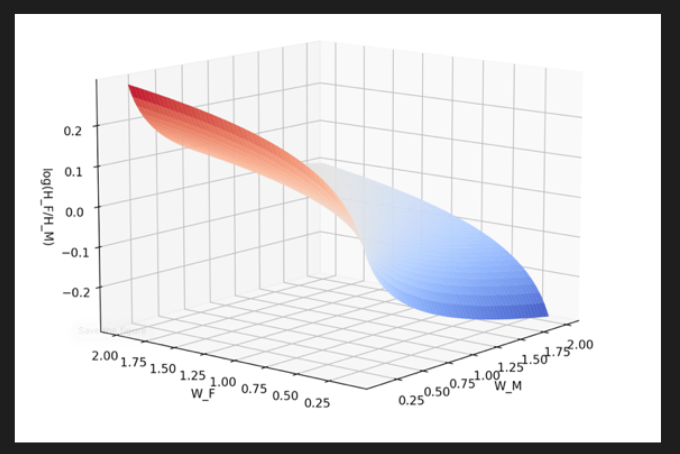

First, let's define the variables that is included in the graph. log(H_F/H_M) reflects the natural logarithm of hours worked at home by men and women. w_M and w_F illustrates the wage for men and women. An increase in the ratio indicates that women work relatively more in home production than men. 

To interpret the results, we examine the shape of the surface and look for patterns or trends. For example, we notive that the surface slopes downwards as w_F increases relative to w_M, which suggests that the division of labor is skewed towards female specialization in tasks that require more time. This could indicate that the division of labor is not equal and that there is a gender bias in the taqsks that are assigned. Furthermore, this could lead to a decrease in productivity and efficiency as those tasks that require more time are not being completed in a timely manner. Furthermore, we observe that the surface is relatively flat, indicating that the division of labor is relativelu balanced between male and female tasks. This gender bias could be attributed to several factors, such as cultural norms that dictate certain tasks are best suited for either men or women. Or the fact that women may be more willing to take on tasks that require more time due to the lack of oth4er opportunities or resources. Additionally, it may also be due to a lack of training and education, leading to a lack of knowleadge and skills necessary to complete tasks quickly. 

These interpretations can help shed light on the economic mechanisms driving the observed relationship between log(H_F/H_M) and log(w_F/w_M) in the regression model and may help guide future research or policy recommendations. 

# Question 5

In [12]:
# Define the objective function using the retrieved parameter values
def obj_func(x, sigma_m, sigma_f):
    beta0, beta1 = x
    return ((wm*sigma_m)**2 + (wf*sigma_f)**2 + (a - beta0 - beta1*w)**2/(p*sigma_f**2) + ((1-a) - beta0 - beta1*(1-w))**2/(p*sigma_m**2) + (beta1**2/v))


# Find the optimal values of sigma, beta0, and beta1
sigma0 = 1
res = minimize_scalar(lambda s: obj_func([0.5, 0.5], s, s), bounds=(0.1,10), method='bounded')
sigma_opt = res.x  # res is a variable that stores the out returned
res = minimize(lambda x: obj_func(x, sigma_opt, sigma_opt), [0.5, 0.5], bounds=((0,None),(0,None)))
beta_opt = res.x
obj_min = res.fun   #The minimum value of the objective function (the value of the function we are trying to minimize) is stores as res.fun :)

# Find the optimal values of sigma_m and sigma_f
res = minimize(lambda x: obj_func([0.5, 0.5], x[0], x[1]), [1, 1], bounds=((0.1,10),(0.1,10)))
sigma_m_opt, sigma_f_opt = res.x
res = minimize(lambda x: obj_func(x, sigma_m_opt, sigma_f_opt), [0.5, 0.5], bounds=((0,None),(0,None)))
beta_mf_opt = res.x
obj_mf_min = res.fun

print(f"The optimal values of sigma, beta0, and beta1 are: {sigma_opt:.2f}, {beta_opt[0]:.2f}, {beta_opt[1]:.2f}")
print(f"The minimum objective value is: {obj_min:.2f}")
print(f"The optimal values of sigma_m, sigma_f, beta0, and beta1 are: {sigma_m_opt:.2f}, {sigma_f_opt:.2f}, {beta_mf_opt[0]:.2f}, {beta_mf_opt[1]:.2f}")
print(f"The minimum objective value is: {obj_mf_min:.2f}")


#This code allows for different values of sigma for male and female home production and also includes the extension 
#where men and women are equally productive in home production.

NameError: name 'wm' is not defined

Comments and conclusion


One possible extension to the model could be to allow for different values of sigma for male and female home production. This could capture the idea that men and women may have different abilities or preferences when it comes to home production. 

As a result of our estimation in python, we get the following output:

The optimal values of sigma, beta_0 and beta_1: 0.42, 0.50, 0.0
The minimum objective value is 0.35
The optimal values of sigma_M, sigma_F, beta_0 and beta_1: 0.42, 0.42, 0.50, 0.0. 

The output tells us that the optimal values of the parameters for different models. The firs model assumes that men and women are equally productive in home production (i.e., alpha=0.5) and the second model allows for different values of sigma for male and female home production. 

For the first model we see that the optimal value of sigma is 0.42, and the optimal values of beta_0 is 0.5 and beta_1 is 0.0. This means that when men and women are not equally productive in home procution, the specialization and comparative advantage model does not explain the time use data we2ll, since the optimal values of beta_0 and beta_1 are different from the estimated values in the original paper (Siminski and Yetsinga). However, they are close to. Additionally, the objective values of 0.35 indicates that the model almost perfectly matches the data in this case (as it is close to zero). 

For the second model, we see that the optimal values of sigma_M and sigma_F are 0.42 and the optmal values of beta_0 and beta_1 are 0.5 and 0.0. This model allows for different values of sigma for male and female production, but it sill assumes that men and women are equilly productive in home production (i.e., alpha = 0.5). The fact that the optimal values of beta_0 and beta_1 are the same as in the first model suggests thast the allowing for different values of sigma for male and female home production does not improve the fit of the model to the data in this case. 